In [1]:
import gc
import os
import re
import math
import random
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm as tqdm
from itertools import compress

import librosa
from scipy.fftpack import fft
from scipy.io import wavfile
from scipy import signal
from scipy.io import wavfile

import keras
from keras import optimizers, losses, activations, models
from keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Bidirectional, Conv1D, GRU
from tensorflow.keras.layers import Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

random.seed(0)
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = 9,6
warnings.filterwarnings('ignore')

In [2]:
# parameters settings
data_path = '../../data/train/audio'
labels = os.listdir(data_path)
CLASSES = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'] 
SAMPLING_RATE = 16000
NOISE_RATIO = 0.1

In [3]:
def pad_audio(samples):
    return np.pad(samples, pad_width=(SAMPLING_RATE - len(samples), 0), mode='constant', constant_values=(0, 0))


def chop_audio(samples):
    return samples[:SAMPLING_RATE]


def split_audio(sample_rate, samples):
    """ Splits audio file to multiple with (up to) fixed 1s length """
    duration = float(len(samples)/sample_rate)
    n_samples = math.ceil(duration)
    return np.array_split(samples, n_samples)

In [4]:
def assign_unknown_label(labels, classes=CLASSES):
    new_labels = []
    for label in labels:
        if label not in classes:
            new_labels.append('unknown')
        else:
            new_labels.append(label)
    return new_labels

def encode_labels(labels):
    return pd.get_dummies(pd.Series(labels))

In [5]:
def specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    _, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return np.log(spec.T.astype(np.float32) + eps)


def plot_model_history(history, title: str) -> None:
    """
    Plotting the learning curve of Keras model, broken down into loss curve and accuracy curve, 
    for both training and validation data.

    Args:
        history : Object returned by the .fit method of Keras model.
        title (str): Title of the plots.
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 

    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')

    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    fig.suptitle(title, size=15)
    plt.show()

In [6]:
def rnn_network(input_dim, output_dim, rnn_layer, optimizer):

    input_data = Input(name='input', shape=input_dim, dtype='float32')

    x = Conv1D(filters=256, kernel_size=10, strides=4, name='conv1d')(input_data)
    x = BatchNormalization(name='b_norm')(x)
    x = Activation('relu', name='activation')(x)
    x = Dropout(DROPOUT, name='dropout_1')(x)
    x = rnn_layer(128, activation='relu', return_sequences=True, dropout=DROPOUT, name='rnn_1')(x)
    x = rnn_layer(128, activation='relu', return_sequences=False, dropout=DROPOUT, name='rnn_2')(x)
    x = Dense(units=64, activation='relu', name='dense')(x)
    x = Dropout(DROPOUT, name='dropout_2')(x)

    output_data = Dense(units=output_dim, activation='softmax', name='softmax')(x)

    model = Model(inputs=input_data, outputs=output_data, name=str(rnn_layer).split(".")[-1].split("'")[0])
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [7]:
def plot_heatmaps(models_results: list, title: str) -> None:
    """
    Plot heatmaps based on the confusion matrices of a given model (basic version and with 2 different augmentations).)

    Args:
        models_results (list): List of confusion matrices of the evaluated models.
        title (str): Title of the plots.
    """
    fig, axes = plt.subplots(1,3,figsize=(18,6))
    models = ['SimpleRNN', 'LSTM', 'GRU']
    for i in range(3):
        sns.heatmap(models_results[i], center=0.5, annot=True,  linewidths=1, linecolor='black', ax=axes[i], annot_kws={"size": 12})
        axes[i].set_title(models[i], size=15)
        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=12)

    fig.suptitle(title, size=18)
    plt.tight_layout()
    plt.show()
    
def plot_confusion_matr(models_results: list, title: str) -> None:
    """
    Plot heatmaps based on the confusion matrices of a given model (basic version and with 2 different augmentations).)

    Args:
        models_results (list): List of confusion matrices of the evaluated models.
        title (str): Title of the plots.
    """
    fig, axes = plt.subplots(1,3,figsize=(18,6))
    models = ['SimpleRNN', 'LSTM', 'GRU']
    for i in range(3):
        sns.heatmap(models_results[i], annot=True, cmap="Blues", ax=axes[i], fmt='d', annot_kws={"size": 12})
        axes[i].set_title(models[i], size=15)
        axes[i].set_xticklabels(axes[i].get_xmajorticklabels(), fontsize = 12)
        axes[i].set_yticklabels(axes[i].get_xmajorticklabels(), fontsize = 12)
        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=12)

    fig.suptitle(title, size=18)
    plt.tight_layout()
    plt.show()

# <span style='font-family:Georgia'> 1. Data loading & preparation

## <span style='font-family:Georgia'> 1.1. Noisy data loading

In [8]:
label = '_background_noise_'
files = [f for f in os.listdir(data_path + '/'+ label) if f.endswith('.wav')]
one_sec_background_noise_specgrams = []

for file in tqdm(files):
    _, samples = wavfile.read(data_path + "/" + label + "/" + file)
    duration = float(len(samples)/SAMPLING_RATE)

    # Do not distinguish between noise classes
    one_sec_background_noise = split_audio(
            sample_rate=SAMPLING_RATE, samples=samples
        )
    
    for item in one_sec_background_noise:
        duration = float(len(item)/SAMPLING_RATE)
        if duration < 1: item = pad_audio(item)        
        
        one_sec_background_noise_specgrams.append(
            specgram(item, SAMPLING_RATE)
        )

  0%|          | 0/6 [00:00<?, ?it/s]

## <span style='font-family:Georgia'> 1.2. Noise-free data loading

In [9]:
validation_list = pd.read_csv('../../data/train/validation_list.txt', sep="\t", header=None)[0].tolist()
testing_list = pd.read_csv('../../data/train/testing_list.txt', sep="\t", header=None)[0].tolist()

In [10]:
print('Training: ', 64721 - len(validation_list) - len(testing_list))
print('Validation: ', len(validation_list))
print('Testing: ', len(testing_list))

Training:  51088
Validation:  6798
Testing:  6835


In [11]:
train_labels = []
train_specgrams = []
val_labels = []
val_specgrams = []
test_labels = []
test_specgrams = []

for label in tqdm([l for l in labels if l != '_background_noise_']):

    files = [f for f in os.listdir(data_path + '/'+ label) if f.endswith('.wav')]
    
    for file in tqdm(files):
        _, samples = wavfile.read(data_path + "/" + label + "/" + file)
        duration = float(len(samples)/SAMPLING_RATE)
                
        if duration < 1: samples = pad_audio(samples)
            
        if (label + "/" + file) in validation_list: 
            val_labels.append(label)
            val_specgrams.append(specgram(samples, SAMPLING_RATE))
        elif (label + "/" + file) in testing_list: 
            test_labels.append(label)
            test_specgrams.append(specgram(samples, SAMPLING_RATE))
        else:
            train_labels.append(label)
            train_specgrams.append(specgram(samples, SAMPLING_RATE))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1713 [00:00<?, ?it/s]

  0%|          | 0/1731 [00:00<?, ?it/s]

  0%|          | 0/1733 [00:00<?, ?it/s]

  0%|          | 0/1746 [00:00<?, ?it/s]

  0%|          | 0/2359 [00:00<?, ?it/s]

  0%|          | 0/2352 [00:00<?, ?it/s]

  0%|          | 0/2357 [00:00<?, ?it/s]

  0%|          | 0/2372 [00:00<?, ?it/s]

  0%|          | 0/2372 [00:00<?, ?it/s]

  0%|          | 0/1742 [00:00<?, ?it/s]

  0%|          | 0/1750 [00:00<?, ?it/s]

  0%|          | 0/2353 [00:00<?, ?it/s]

  0%|          | 0/1746 [00:00<?, ?it/s]

  0%|          | 0/2364 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/2357 [00:00<?, ?it/s]

  0%|          | 0/2367 [00:00<?, ?it/s]

  0%|          | 0/2370 [00:00<?, ?it/s]

  0%|          | 0/2367 [00:00<?, ?it/s]

  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/1734 [00:00<?, ?it/s]

  0%|          | 0/2369 [00:00<?, ?it/s]

  0%|          | 0/2380 [00:00<?, ?it/s]

  0%|          | 0/2356 [00:00<?, ?it/s]

  0%|          | 0/1733 [00:00<?, ?it/s]

  0%|          | 0/2373 [00:00<?, ?it/s]

  0%|          | 0/2375 [00:00<?, ?it/s]

  0%|          | 0/1745 [00:00<?, ?it/s]

  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/2376 [00:00<?, ?it/s]

## <span style='font-family:Georgia'> 1.3. Data labeling

### <span style='font-family:Georgia'> 1.3.1. Noise-free data split (for hyperparameters tuning)

In [12]:
X_train = np.array(train_specgrams)
X_val = np.array(val_specgrams)
X_test = np.array(test_specgrams)

Y_train = assign_unknown_label(train_labels)
Y_val = assign_unknown_label(val_labels)
Y_test = assign_unknown_label(test_labels)

Y_train = np.array(encode_labels(Y_train).values)
Y_val = np.array(encode_labels(Y_val).values)
Y_test = np.array(encode_labels(Y_test).values)

### <span style='font-family:Georgia'> 1.3.2. Approach 1 - taking `background_noise` observations as separate `silence` class

In [13]:
# Split noise into 3 disjoint subsets (train, valid & test sets)
N = 64721
valid_ratio = np.round(len(validation_list)/N, 2)
test_ratio = np.round(len(testing_list)/N, 2)
train_ratio = 1 - (valid_ratio+test_ratio)

sets_list = ["train", "val", "test"]
obs_split = np.array(random.choices(sets_list, weights=(train_ratio, valid_ratio, test_ratio), k=N))
train_mask, val_mask, test_mask = obs_split == "train", obs_split == "val", obs_split == "test"

In [14]:
train_noise = list(compress(one_sec_background_noise_specgrams, train_mask))
print(f'Number of observations assigned to train set: {len(train_noise)}')

val_noise = list(compress(one_sec_background_noise_specgrams, val_mask))
print(f'Number of observations assigned to validation set: {len(val_noise)}')

test_noise = list(compress(one_sec_background_noise_specgrams, test_mask))
print(f'Number of observations assigned to test set: {len(test_noise)}')

Number of observations assigned to train set: 303
Number of observations assigned to validation set: 48
Number of observations assigned to test set: 51


In [15]:
train_specgrams_1 = train_specgrams + train_noise
train_labels_1 = train_labels + ['silence' for i in range(len(train_noise))]

val_specgrams_1 = val_specgrams + val_noise
val_labels_1 = val_labels + ['silence' for i in range(len(val_noise))]

test_specgrams_1 = test_specgrams + test_noise
test_labels_1 = test_labels + ['silence' for i in range(len(test_noise))]

In [16]:
x_train_1 = np.array(train_specgrams_1)
print(x_train_1.shape)

x_val_1 = np.array(val_specgrams_1)
print(x_val_1.shape)

x_test_1 = np.array(test_specgrams_1)
print(x_test_1.shape)

(51391, 99, 161)
(6846, 99, 161)
(6886, 99, 161)


In [17]:
classes=CLASSES+['silence']

y_train_1 = assign_unknown_label(train_labels_1, classes=classes)
print(np.unique(y_train_1))

y_val_1 = assign_unknown_label(val_labels_1, classes=classes)
print(np.unique(y_val_1))

y_test_1 = assign_unknown_label(test_labels_1, classes=classes)
print(np.unique(y_test_1))

['down' 'go' 'left' 'no' 'off' 'on' 'right' 'silence' 'stop' 'unknown'
 'up' 'yes']
['down' 'go' 'left' 'no' 'off' 'on' 'right' 'silence' 'stop' 'unknown'
 'up' 'yes']
['down' 'go' 'left' 'no' 'off' 'on' 'right' 'silence' 'stop' 'unknown'
 'up' 'yes']


In [18]:
del train_specgrams_1, val_specgrams_1, test_specgrams_1
del train_labels_1, val_labels_1, test_labels_1
gc.collect()

268

In [19]:
# Labels encoding
y_train_1 = np.array(encode_labels(y_train_1).values)
y_val_1 = np.array(encode_labels(y_val_1).values)
y_test_1 = np.array(encode_labels(y_test_1).values)

### <span style='font-family:Georgia'> 1.3.2. Approach 2 - noising the training subset(s) with the 'background_noise' class observations

In [20]:
train_labels_summary = pd.Series(train_labels).value_counts()
n = math.floor(NOISE_RATIO*train_labels_summary.sum())
noised_labels = random.choices(train_labels, k=n)

summary = pd.DataFrame(train_labels_summary, columns=["obs_cnt"])
summary["noise_cnt"] = pd.Series(noised_labels).value_counts()
summary["noise_ratio"] = summary["noise_cnt"] / summary["obs_cnt"]
summary

,obs_cnt,noise_cnt,noise_ratio
one,1892,204,0.107822
stop,1885,185,0.098143
nine,1875,170,0.090667
seven,1875,173,0.092267
two,1873,167,0.089162
zero,1866,166,0.088960
on,1864,183,0.098176
six,1863,181,0.097155
go,1861,163,0.087587
yes,1860,191,0.102688


In [21]:
train_specgrams_2 = train_specgrams + random.choices(one_sec_background_noise_specgrams, k=n)
train_labels_2 = train_labels + noised_labels

In [22]:
x_train_2 = np.array(train_specgrams_2)
print(x_train_2.shape)

(56196, 99, 161)


In [23]:
y_train_2 = assign_unknown_label(train_labels_2)
print(np.unique(y_train_2))

['down' 'go' 'left' 'no' 'off' 'on' 'right' 'stop' 'unknown' 'up' 'yes']


In [24]:
# Labels encoding
y_train_2 = np.array(encode_labels(y_train_2).values)

In [25]:
del train_specgrams_2, train_labels_2
del train_specgrams, val_specgrams, test_specgrams
del train_labels, val_labels, test_labels

gc.collect()

75

# <span style='font-family:Georgia'> 2. Modeling

In [26]:
MIN_DELTA=1e-4
DROPOUT = 0.2

## <span style='font-family:Georgia'> 2.1. Tuning hyperparameters

### <span style='font-family:Georgia'> 2.1.1. Learning rate & batch size tuning

In [27]:
# hyperparameters set-up
INPUT_DIM = (X_train.shape[1], X_train.shape[2])
OUTPUT_DIM = Y_train.shape[1]

Y_test_classes = np.argmax(Y_test, axis=1)

In [28]:
ITER = 2  # TODO: increase ITER number
EPOCHS = 3  # TODO: increase EPOCHS number
PATIENCE=int(EPOCHS/3)
learning_rate = [1e-4, 1e-3, 1e-2]  # TODO: expand parameters grids
batch_size = [128, 256]  # TODO: expand parameters grids

In [29]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=PATIENCE, min_delta=MIN_DELTA)

In [30]:
model1_acc_all, model2_acc_all, model3_acc_all = [], [], []

for lr in tqdm(learning_rate):
    model1_acc_lr, model2_acc_lr, model3_acc_lr = [], [], []
    
    for size in tqdm(batch_size):
        model1_acc_bs, model2_acc_bs, model3_acc_bs = [], [], []        
    
        for i in tqdm(range(ITER)):
            OPT = Adam(learning_rate=lr, clipnorm=1.0)
            # SimpleRNN
            model1 = rnn_network(INPUT_DIM, OUTPUT_DIM, SimpleRNN, OPT)
            K.clear_session()
            model1_history = model1.fit(X_train, Y_train,
                                        batch_size=size, epochs=EPOCHS, verbose=1,
                                        validation_data=(X_val, Y_val),
                                        callbacks=[early_stop]
                                       )

            # LSTM
            model2 = rnn_network(INPUT_DIM, OUTPUT_DIM, LSTM, OPT)
            K.clear_session()
            model2_history = model2.fit(X_train, Y_train,
                                        batch_size=size, epochs=EPOCHS, verbose=1,
                                        validation_data=(X_val, Y_val),
                                        callbacks=[early_stop]
                                       )

            # GRU
            model3 = rnn_network(INPUT_DIM, OUTPUT_DIM, GRU, OPT)
            K.clear_session()
            model3_history = model3.fit(X_train, Y_train,
                                        batch_size=size, epochs=EPOCHS, verbose=1,
                                        validation_data=(X_val, Y_val),
                                        callbacks=[early_stop]
                                       )
            
            # Save models predictions accuracies for each iteration
            y_pred_1 = model1.predict(X_test)
            y_pred_2 = model2.predict(X_test)
            y_pred_3 = model3.predict(X_test)
            y_pred_classes_1 = np.argmax(y_pred_1, axis=-1)
            y_pred_classes_2 = np.argmax(y_pred_2, axis=-1)
            y_pred_classes_3 = np.argmax(y_pred_3, axis=-1)

            model1_acc_bs.append(accuracy_score(Y_test_classes, y_pred_classes_1))
            model2_acc_bs.append(accuracy_score(Y_test_classes, y_pred_classes_2))
            model3_acc_bs.append(accuracy_score(Y_test_classes, y_pred_classes_3))

        model1_acc_lr.append(model1_acc_bs)
        model2_acc_lr.append(model2_acc_bs)
        model3_acc_lr.append(model3_acc_bs)
        
    # Save models results for each learning rate
    model1_acc_all.append(model1_acc_lr)
    model2_acc_all.append(model2_acc_lr)
    model3_acc_all.append(model3_acc_lr)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/3
400/400 [==============================] - 98s 233ms/step - loss: 1.5809 - accuracy: 0.5968 - val_loss: 1.3354 - val_accuracy: 0.6208
Epoch 2/3
400/400 [==============================] - 102s 254ms/step - loss: 1.2892 - accuracy: 0.6323 - val_loss: 1.1659 - val_accuracy: 0.6236
Epoch 3/3
400/400 [==============================] - 100s 250ms/step - loss: 1.1642 - accuracy: 0.6361 - val_loss: 1.0360 - val_accuracy: 0.6486
Epoch 1/3
400/400 [==============================] - 188s 455ms/step - loss: 1.1392 - accuracy: 0.6715 - val_loss: 0.7364 - val_accuracy: 0.7558
Epoch 2/3
400/400 [==============================] - 174s 436ms/step - loss: 0.6282 - accuracy: 0.8014 - val_loss: 0.4855 - val_accuracy: 0.8486
Epoch 3/3
400/400 [==============================] - 172s 430ms/step - loss: 0.4572 - accuracy: 0.8580 - val_loss: 0.3734 - val_accuracy: 0.8838
Epoch 1/3
400/400 [==============================] - 180s 435ms/step - loss: 1.0288 - accuracy: 0.6948 - val_loss: 0.5446 - val_acc

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/3
200/200 [==============================] - 119s 570ms/step - loss: 1.5498 - accuracy: 0.6216 - val_loss: 1.4152 - val_accuracy: 0.6209
Epoch 2/3
200/200 [==============================] - 113s 566ms/step - loss: 1.3610 - accuracy: 0.6346 - val_loss: 1.2805 - val_accuracy: 0.6212
Epoch 3/3
200/200 [==============================] - 91s 454ms/step - loss: 1.2724 - accuracy: 0.6346 - val_loss: 1.2200 - val_accuracy: 0.6237
Epoch 1/3
200/200 [==============================] - 165s 794ms/step - loss: 1.2912 - accuracy: 0.6491 - val_loss: 1.0372 - val_accuracy: 0.6830
Epoch 2/3
200/200 [==============================] - 161s 804ms/step - loss: 0.8165 - accuracy: 0.7375 - val_loss: 0.6761 - val_accuracy: 0.7933
Epoch 3/3
200/200 [==============================] - 161s 808ms/step - loss: 0.6056 - accuracy: 0.8056 - val_loss: 0.5055 - val_accuracy: 0.8503
Epoch 1/3
200/200 [==============================] - 155s 744ms/step - loss: 1.2571 - accuracy: 0.6456 - val_loss: 0.8644 - val_acc

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/3
400/400 [==============================] - 69s 168ms/step - loss: 1.2814 - accuracy: 0.6394 - val_loss: 1.1722 - val_accuracy: 0.6453
Epoch 2/3
400/400 [==============================] - 67s 168ms/step - loss: 0.8943 - accuracy: 0.7088 - val_loss: 0.7528 - val_accuracy: 0.7526
Epoch 3/3
400/400 [==============================] - 67s 167ms/step - loss: 0.6274 - accuracy: 0.8049 - val_loss: 0.4667 - val_accuracy: 0.8628
Epoch 1/3
400/400 [==============================] - 111s 270ms/step - loss: 173.7193 - accuracy: 0.6365 - val_loss: 0.8494 - val_accuracy: 0.7086
Epoch 2/3
400/400 [==============================] - 106s 266ms/step - loss: 0.6756 - accuracy: 0.7823 - val_loss: 0.5095 - val_accuracy: 0.8288
Epoch 3/3
400/400 [==============================] - 107s 267ms/step - loss: 0.4317 - accuracy: 0.8660 - val_loss: 0.3337 - val_accuracy: 0.8995
Epoch 1/3
400/400 [==============================] - 107s 259ms/step - loss: 0.8128 - accuracy: 0.7515 - val_loss: 0.4346 - val_acc

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/3
200/200 [==============================] - 88s 429ms/step - loss: 1.4015 - accuracy: 0.6250 - val_loss: 2.7355 - val_accuracy: 0.6330
Epoch 2/3
200/200 [==============================] - 83s 417ms/step - loss: 1.0143 - accuracy: 0.6720 - val_loss: 0.8563 - val_accuracy: 0.7014
Epoch 3/3
200/200 [==============================] - 82s 410ms/step - loss: 0.7686 - accuracy: 0.7420 - val_loss: 0.5926 - val_accuracy: 0.8030
Epoch 1/3
200/200 [==============================] - 148s 729ms/step - loss: 1.5672 - accuracy: 0.6340 - val_loss: 0.9781 - val_accuracy: 0.6687
Epoch 2/3
200/200 [==============================] - 131s 656ms/step - loss: 0.7454 - accuracy: 0.7582 - val_loss: 0.5273 - val_accuracy: 0.8277
Epoch 3/3
200/200 [==============================] - 128s 641ms/step - loss: 0.4662 - accuracy: 0.8493 - val_loss: 0.4501 - val_accuracy: 0.8604
Epoch 1/3
200/200 [==============================] - 122s 596ms/step - loss: 0.9246 - accuracy: 0.7229 - val_loss: 0.5703 - val_accur

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/3
400/400 [==============================] - 96s 236ms/step - loss: 1.3910 - accuracy: 0.6352 - val_loss: 1.2415 - val_accuracy: 0.6234
Epoch 2/3
400/400 [==============================] - 93s 234ms/step - loss: 1.2412 - accuracy: 0.6345 - val_loss: 1.2281 - val_accuracy: 0.6209
Epoch 1/3
400/400 [==============================] - 164s 406ms/step - loss: 5645306.5000 - accuracy: 0.6335 - val_loss: 1.5394 - val_accuracy: 0.6209
Epoch 2/3
400/400 [==============================] - 157s 393ms/step - loss: 1.4942 - accuracy: 0.6371 - val_loss: 1.5412 - val_accuracy: 0.6209
Epoch 1/3
400/400 [==============================] - 153s 376ms/step - loss: 1.4119 - accuracy: 0.6434 - val_loss: 0.9859 - val_accuracy: 0.6717
Epoch 2/3
400/400 [==============================] - 148s 369ms/step - loss: 0.8753 - accuracy: 0.7140 - val_loss: 0.6233 - val_accuracy: 0.7910
Epoch 3/3
400/400 [==============================] - 150s 376ms/step - loss: 0.6882 - accuracy: 0.7793 - val_loss: 0.5250 - va

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/3
200/200 [==============================] - 90s 443ms/step - loss: 1.6841 - accuracy: 0.6343 - val_loss: 1.3548 - val_accuracy: 0.6209
Epoch 2/3
200/200 [==============================] - 88s 440ms/step - loss: 1.2315 - accuracy: 0.6407 - val_loss: 1.2111 - val_accuracy: 0.6421
Epoch 3/3
200/200 [==============================] - 88s 440ms/step - loss: 1.1733 - accuracy: 0.6480 - val_loss: 1.1949 - val_accuracy: 0.6315
Epoch 1/3
200/200 [==============================] - 151s 743ms/step - loss: 12934639.0000 - accuracy: 0.6253 - val_loss: 1.2577 - val_accuracy: 0.6233
Epoch 2/3
200/200 [==============================] - 148s 738ms/step - loss: 1.1051 - accuracy: 0.6728 - val_loss: 0.8902 - val_accuracy: 0.7111
Epoch 3/3
200/200 [==============================] - 150s 749ms/step - loss: 0.8569 - accuracy: 0.7235 - val_loss: 0.6975 - val_accuracy: 0.7638
Epoch 1/3
200/200 [==============================] - 135s 660ms/step - loss: 1.4745 - accuracy: 0.6399 - val_loss: 1.0927 - va

### <span style='font-family:Georgia'> 2.1.2. Tuning results summary

In [31]:
acc_all = []
model_1_acc_lr, model_2_acc_lr, model_3_acc_lr = [], [], []

for i in range(len(learning_rate)):
    model_1_acc_bs, model_2_acc_bs, model_3_acc_bs = [], [], []
    for j in range(len(batch_size)):
        # mean over iterations (mean score for each learning_rate-batch_size pair)
        model_1_acc_bs.append(np.mean(model1_acc_all[i][j]))
        model_2_acc_bs.append(np.mean(model2_acc_all[i][j]))
        model_3_acc_bs.append(np.mean(model3_acc_all[i][j]))
        
    model_1_acc_lr.append(model_1_acc_bs)
    model_2_acc_lr.append(model_2_acc_bs)
    model_3_acc_lr.append(model_3_acc_bs)
        
    # mean over batch_sized (mean score for each learning_rate)
    acc_all.append([
        np.mean(model_1_acc_lr),
        np.mean(model_2_acc_lr),
        np.mean(model_3_acc_lr)
    ])

In [32]:
# Accuracy depending on both: Learning rate & Batch size

In [33]:
models_results = [
    pd.DataFrame(model_1_acc_lr, columns=batch_size, index=learning_rate),
    pd.DataFrame(model_2_acc_lr, columns=batch_size, index=learning_rate),
    pd.DataFrame(model_3_acc_lr, columns=batch_size, index=learning_rate)
]

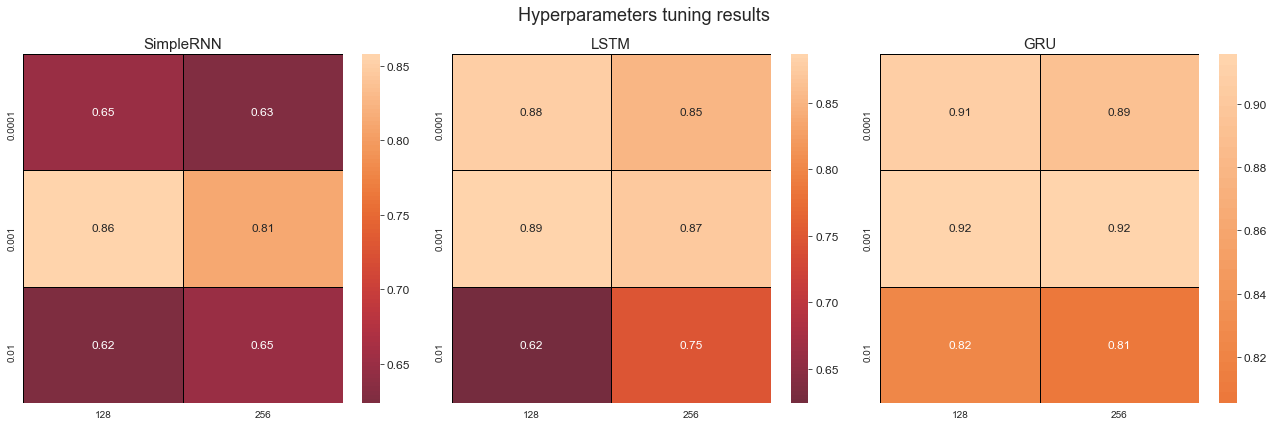

In [34]:
plot_heatmaps(models_results, title="Hyperparameters tuning results")

In [35]:
# Accuracy depending on both: Learning rate (mean over batch size)

In [36]:
results_acc = pd.DataFrame(acc_all)
results_acc.columns = ['SimpleRNN', 'LSTM', 'GRU']
results_acc.index = learning_rate
results_acc.index.name = "Learning rate"
results_acc_melted = pd.melt(results_acc.reset_index(), id_vars=['Learning rate'], value_vars=['SimpleRNN', 'LSTM', 'GRU'])
results_acc_melted.columns=['Learning rate', 'Model', 'Accuracy']
results_acc.reset_index(inplace=True)

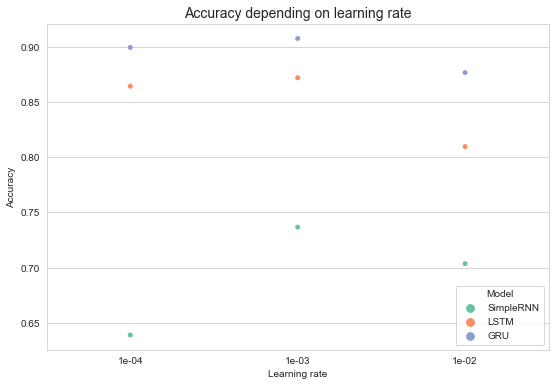

In [37]:
for j in range(results_acc_melted.shape[0]):
    results_acc_melted.loc[j, 'Learning rate'] = '{:.0e}'.format(results_acc_melted.loc[j, 'Learning rate'])
sns.stripplot(x="Learning rate", y="Accuracy", hue="Model",
               data=results_acc_melted, palette="Set2", dodge=False, jitter=0.0)    
plt.title("Accuracy depending on learning rate", size=14);

### <span style='font-family:Georgia'> 2.1.3. Tuned models overview

In [38]:
# TODO: select the best learning rate & batch size pair for each model
EPOCHS = 3  # TODO: increase EPOCHS number
MODELS = ['SimpleRNN', 'LSTM', 'GRU']
LEARNING_RATES = [1e-3, 1e-4, 1e-3]
BATCH_SIZES = [128, 128, 128]

# SimpleRNN
OPT = Adam(learning_rate=LEARNING_RATES[0], clipnorm=1.0)
model1 = rnn_network(INPUT_DIM, OUTPUT_DIM, SimpleRNN, OPT)
K.clear_session()
model1_history = model1.fit(X_train, Y_train,
                            batch_size=BATCH_SIZES[0], epochs=EPOCHS, verbose=1,
                            validation_data=(X_val, Y_val),
                            callbacks=[early_stop]
                           )

# LSTM
OPT = Adam(learning_rate=LEARNING_RATES[1], clipnorm=1.0)
model2 = rnn_network(INPUT_DIM, OUTPUT_DIM, LSTM, OPT)
K.clear_session()
model2_history = model2.fit(X_train, Y_train,
                            batch_size=BATCH_SIZES[1], epochs=EPOCHS, verbose=1,
                            validation_data=(X_val, Y_val),
                            callbacks=[early_stop]
                           )

# GRU
OPT = Adam(learning_rate=LEARNING_RATES[2], clipnorm=1.0)
model3 = rnn_network(INPUT_DIM, OUTPUT_DIM, GRU, OPT)
K.clear_session()
model3_history = model3.fit(X_train, Y_train,
                            batch_size=BATCH_SIZES[2], epochs=EPOCHS, verbose=1,
                            validation_data=(X_val, Y_val),
                            callbacks=[early_stop]
                           )

# Save models predictions accuracies for each iteration
y_pred_1 = model1.predict(X_test)
y_pred_2 = model2.predict(X_test)
y_pred_3 = model3.predict(X_test)
y_pred_classes_1 = np.argmax(y_pred_1, axis=-1)
y_pred_classes_2 = np.argmax(y_pred_2, axis=-1)
y_pred_classes_3 = np.argmax(y_pred_3, axis=-1)

Epoch 1/3
400/400 [==============================] - 107s 263ms/step - loss: 1.3023 - accuracy: 0.6323 - val_loss: 1.0556 - val_accuracy: 0.6487
Epoch 2/3
400/400 [==============================] - 105s 262ms/step - loss: 0.8774 - accuracy: 0.7187 - val_loss: 0.6152 - val_accuracy: 0.7983
Epoch 3/3
400/400 [==============================] - 105s 263ms/step - loss: 0.6047 - accuracy: 0.8089 - val_loss: 0.4969 - val_accuracy: 0.8364
Epoch 1/3
400/400 [==============================] - 181s 445ms/step - loss: 1.3559 - accuracy: 0.6313 - val_loss: 1.1507 - val_accuracy: 0.6805
Epoch 2/3
400/400 [==============================] - 178s 445ms/step - loss: 0.8868 - accuracy: 0.7249 - val_loss: 0.6750 - val_accuracy: 0.7919
Epoch 3/3
400/400 [==============================] - 178s 446ms/step - loss: 0.6397 - accuracy: 0.7976 - val_loss: 0.4907 - val_accuracy: 0.8497
Epoch 1/3
400/400 [==============================] - 165s 406ms/step - loss: 0.8529 - accuracy: 0.7466 - val_loss: 0.3880 - val_ac

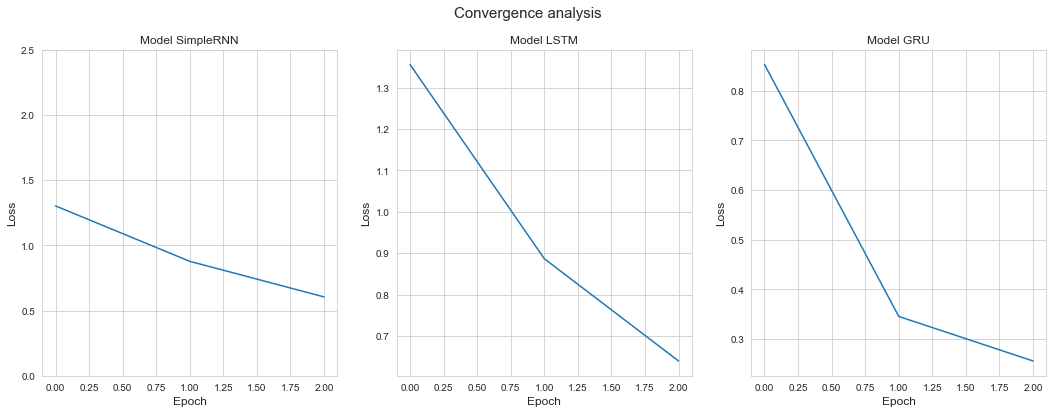

In [39]:
# Convergence analysis
models_history = [model1_history, model2_history, model3_history]

fig, axes = plt.subplots(1,3,figsize=(18,6))
models = ['1', '2', '3']
for i in range(3):
    model_name=MODELS[i]
    history = models_history[i]
    data_lr = history.history['loss']
    sns.lineplot(data=data_lr, ax=axes[i])
    if i == 0 : axes[i].set_ylim([0,2.5]) # due to huge loss values for 1e-2 (to make other lines visible)
    axes[i].set_title('Model '+model_name)
    axes[i].set_xlabel('Epoch', size=12)
    axes[i].set_ylabel('Loss', size=12)
fig.suptitle("Convergence analysis", size=15)
plt.show()

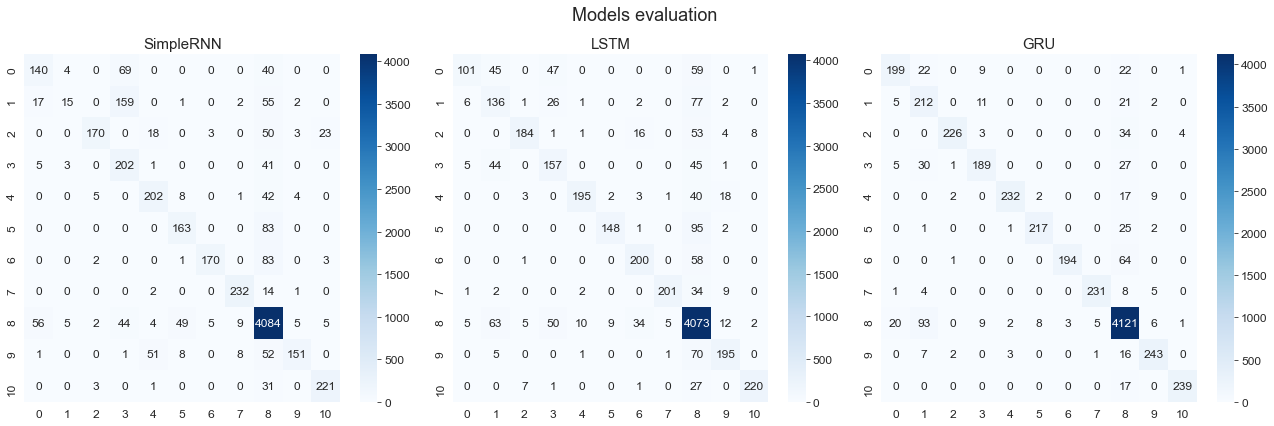

In [40]:
# Models evaluation- confusion matrices
models_results = [pd.DataFrame(confusion_matrix(Y_test_classes, y_pred_classes_1)),
                  pd.DataFrame(confusion_matrix(Y_test_classes, y_pred_classes_2)),
                  pd.DataFrame(confusion_matrix(Y_test_classes, y_pred_classes_3))]

plot_confusion_matr(models_results, 'Models evaluation')

## <span style='font-family:Georgia'> 2.2. Noise data handling

### <span style='font-family:Georgia'> 2.2.1. Approach 1 - taking `background_noise` observations as separate `silence` class

In [41]:
x_train, x_val, x_test = x_train_1, x_val_1, x_test_1
y_train, y_val, y_test = y_train_1, y_val_1, y_test_1

In [44]:
# hyperparameters set-up
INPUT_DIM = (x_train.shape[1], x_train.shape[2])
OUTPUT_DIM = y_train.shape[1]

early_stop = EarlyStopping(monitor='val_accuracy', patience=PATIENCE, min_delta=MIN_DELTA)

# TODO: Choose best LR & BATCH_SIZE
BATCH_SIZE = 128
LR = 1e-4
OPT = Adam(learning_rate=LR, clipnorm=1.0)

In [45]:
# Models training
model1_stats = []
model1_acc = []
model2_stats = []
model2_acc = []
model3_stats = []
model3_acc = []

for i in tqdm(range(ITER)):
    # SimpleRNN
    model1 = rnn_network(INPUT_DIM, OUTPUT_DIM, SimpleRNN, OPT)
    K.clear_session()
    model1_history = model1.fit(x_train, y_train,
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stop]
                               )
    
    # LSTM
    model2 = rnn_network(INPUT_DIM, OUTPUT_DIM, LSTM, OPT)
    K.clear_session()
    model2_history = model2.fit(x_train, y_train,
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stop]
                               )
    
    # GRU
    model3 = rnn_network(INPUT_DIM, OUTPUT_DIM, GRU, OPT)
    K.clear_session()
    model3_history = model3.fit(x_train, y_train,
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stop]
                               )
    
    # Saving results
    y_test_classes = np.argmax(y_test, axis=1)
    
    model1_stats.append(model1_history)
    y_pred_1 = model1.predict(x_test)
    y_pred_classes_1 = np.argmax(y_pred_1, axis=-1)
    model1_acc.append(accuracy_score(y_test_classes, y_pred_classes_1))

    model2_stats.append(model2_history)
    y_pred_2 = model2.predict(x_test)
    y_pred_classes_2 = np.argmax(y_pred_2, axis=-1)
    model2_acc.append(accuracy_score(y_test_classes, y_pred_classes_2))
    
    model3_stats.append(model3_history)
    y_pred_3 = model3.predict(x_test)
    y_pred_classes_3 = np.argmax(y_pred_3, axis=-1)
    model3_acc.append(accuracy_score(y_test_classes, y_pred_classes_3))

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/3
402/402 [==============================] - 112s 274ms/step - loss: 1.5349 - accuracy: 0.6228 - val_loss: 1.3779 - val_accuracy: 0.6218
Epoch 2/3
402/402 [==============================] - 103s 257ms/step - loss: 1.3072 - accuracy: 0.6324 - val_loss: 1.2025 - val_accuracy: 0.6278
Epoch 3/3
402/402 [==============================] - 104s 259ms/step - loss: 1.1746 - accuracy: 0.6399 - val_loss: 1.0566 - val_accuracy: 0.6471
Epoch 1/3
402/402 [==============================] - 172s 422ms/step - loss: 1.2702 - accuracy: 0.6491 - val_loss: 0.8919 - val_accuracy: 0.7083
Epoch 2/3
402/402 [==============================] - 169s 420ms/step - loss: 0.7569 - accuracy: 0.7622 - val_loss: 0.5308 - val_accuracy: 0.8295
Epoch 3/3
402/402 [==============================] - 168s 418ms/step - loss: 0.5209 - accuracy: 0.8380 - val_loss: 0.4122 - val_accuracy: 0.8704
Epoch 1/3
402/402 [==============================] - 164s 401ms/step - loss: 1.0999 - accuracy: 0.6814 - val_loss: 0.6021 - val_ac

In [46]:
# Models summary
approach1_acc_results = pd.DataFrame([model1_acc, model2_acc, model3_acc]).T
approach1_acc_results.columns=['SimpleRNN', 'LSTM', 'GRU']
approach1_acc_results_stats = approach1_acc_results.describe().T[['mean', 'std', 'min', 'max']]

In [47]:
model1_epochs = []
model2_epochs = []
model3_epochs = []
for i in range(ITER):
    model1_epochs.append(len(model1_stats[i].history['loss']))
    model2_epochs.append(len(model2_stats[i].history['loss']))
    model3_epochs.append(len(model3_stats[i].history['loss']))
    
approach1_acc_results_stats['epochs'] = [np.array(model1_epochs).mean(), np.array(model2_epochs).mean(),
                                      np.array(model3_epochs).mean()]
approach1_acc_results_stats

,mean,std,min,max,epochs
SimpleRNN,0.682254,0.051344,0.645948,0.718559,3.0
LSTM,0.881208,0.010269,0.873947,0.888469,3.0
GRU,0.909309,0.000308,0.909091,0.909527,3.0


### <span style='font-family:Georgia'> 2.2.2. Approach 2 - noising the training subset(s) with the `background_noise` class observations

In [48]:
x_train, x_val, x_test = x_train_2, X_val, X_test
y_train, y_val, y_test = y_train_2, Y_val, Y_test

In [49]:
# hyperparameters set-up
INPUT_DIM = (x_train.shape[1], x_train.shape[2])
OUTPUT_DIM = y_train.shape[1]

early_stop = EarlyStopping(monitor='val_accuracy', patience=PATIENCE, min_delta=MIN_DELTA)

# TODO: Choose best LR & BATCH_SIZE
BATCH_SIZE = 128
LR = 1e-4
OPT = Adam(learning_rate=LR, clipnorm=1.0)

In [50]:
# Models training
model4_stats = []
model4_acc = []
model5_stats = []
model5_acc = []
model6_stats = []
model6_acc = []

for i in tqdm(range(ITER)):
    # SimpleRNN
    model4 = rnn_network(INPUT_DIM, OUTPUT_DIM, SimpleRNN, OPT)
    K.clear_session()
    model4_history = model4.fit(x_train, y_train,
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stop]
                               )
    
    # LSTM
    model5 = rnn_network(INPUT_DIM, OUTPUT_DIM, LSTM, OPT)
    K.clear_session()
    
    model5_history = model5.fit(x_train, y_train,
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stop]
                               )
    
    # GRU
    model6 = rnn_network(INPUT_DIM, OUTPUT_DIM, GRU, OPT)
    K.clear_session()
    model6_history = model6.fit(x_train, y_train,
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stop]
                               )
    
    # Saving results
    y_test_classes = np.argmax(y_test, axis=1)
    
    model4_stats.append(model4_history)
    y_pred_4 = model4.predict(x_test)
    y_pred_classes_4 = np.argmax(y_pred_4, axis=-1)
    model4_acc.append(accuracy_score(y_test_classes, y_pred_classes_4))

    model5_stats.append(model5_history)
    y_pred_5 = model5.predict(x_test)
    y_pred_classes_5 = np.argmax(y_pred_5, axis=-1)
    model5_acc.append(accuracy_score(y_test_classes, y_pred_classes_5))
    
    model6_stats.append(model6_history)
    y_pred_6 = model6.predict(x_test)
    y_pred_classes_6 = np.argmax(y_pred_6, axis=-1)
    model6_acc.append(accuracy_score(y_test_classes, y_pred_classes_6))

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/3
440/440 [==============================] - 134s 298ms/step - loss: 1.5334 - accuracy: 0.6205 - val_loss: 1.3260 - val_accuracy: 0.6211
Epoch 2/3
440/440 [==============================] - 117s 266ms/step - loss: 1.3267 - accuracy: 0.6364 - val_loss: 1.2292 - val_accuracy: 0.6274
Epoch 3/3
440/440 [==============================] - 120s 272ms/step - loss: 1.2255 - accuracy: 0.6464 - val_loss: 1.0551 - val_accuracy: 0.6711
Epoch 1/3
440/440 [==============================] - 218s 491ms/step - loss: 1.2274 - accuracy: 0.6599 - val_loss: 0.8067 - val_accuracy: 0.7510
Epoch 2/3
440/440 [==============================] - 209s 474ms/step - loss: 0.7808 - accuracy: 0.7642 - val_loss: 0.4942 - val_accuracy: 0.8395
Epoch 3/3
440/440 [==============================] - 225s 511ms/step - loss: 0.6015 - accuracy: 0.8196 - val_loss: 0.4144 - val_accuracy: 0.8725
Epoch 1/3
440/440 [==============================] - 185s 413ms/step - loss: 1.1065 - accuracy: 0.6840 - val_loss: 0.5754 - val_ac

In [51]:
# Models summary
approach2_acc_results = pd.DataFrame([model4_acc, model5_acc, model6_acc]).T
approach2_acc_results.columns=['SimpleRNN', 'LSTM', 'GRU']
approach2_acc_results_stats = approach2_acc_results.describe().T[['mean', 'std', 'min', 'max']]

In [52]:
model4_epochs = []
model5_epochs = []
model6_epochs = []
for i in range(ITER):
    model4_epochs.append(len(model4_stats[i].history['loss']))
    model5_epochs.append(len(model5_stats[i].history['loss']))
    model6_epochs.append(len(model6_stats[i].history['loss']))
    
approach2_acc_results_stats['epochs'] = [np.array(model4_epochs).mean(), np.array(model5_epochs).mean(),
                                      np.array(model6_epochs).mean()]
approach2_acc_results_stats

,mean,std,min,max,epochs
SimpleRNN,0.672495,0.002173,0.670958,0.674031,3.0
LSTM,0.877249,0.002069,0.875786,0.878713,3.0
GRU,0.907388,0.006621,0.902707,0.912070,3.0
